# **Lung Segmentation from Chest CT Scans using Deep Learning**



## Installing dependencies

In [ ]:
# Install required libraries
!pip install SimpleITK==2.0.2 albumentations connected-components-3d --quiet

In [ ]:
# Installing the main Deep learning libraries
!pip install torch==2.0.0 pytorch_lightning==2.0.1 torchvision==0.15.* --quiet

In [ ]:
pip install scikit-image
pip install skimage
pip install nibabel
pip install unzip

pip install scikit-learn seaborn
pip install scikit-learn matplotlib seaborn
pip install imageio nibabel


## Imports

In [2]:
import os
import imageio
import albumentations as A
import random
import zipfile
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import multiprocessing as mp
import matplotlib.pyplot as plt
import cc3d
import numpy as np
import SimpleITK as sitk
from math import nan
from typing import List, Dict, Union
from skimage.measure import regionprops
from glob import iglob, glob
from tqdm import tqdm
from argparse import Namespace
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import Compose
from typing import Tuple
from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import NeptuneLogger

%load_ext tensorboard

In [3]:
# Check libraries version!
import torch
import pytorch_lightning as pl

print(f"PyTorch version: {torch.__version__}")
print(f"Pytorch Lightning version: {pl.__version__}")

PyTorch version: 2.0.0+cpu
Pytorch Lightning version: 2.0.1


### Downloading raw data
COVID-19 cases with annotation - download dataset here:
  https://zenodo.org/record/3757476#.YtmeJ9KZM1g

In [4]:
# Downloading raw data
import urllib.request

zip_filename = "raw.zip"
if not os.path.exists(zip_filename):
    url = "https://github.com/MICLab-Unicamp/Public-data/releases/download/v1.0/raw.zip"
    print(f"Downloading from: {url}")
    urllib.request.urlretrieve(url, zip_filename)
    print("Download complete.")
else:
    print("raw.zip already exists.")


raw.zip already exists.


In [5]:

# Preview contents of raw.zip - Unpacking data
with zipfile.ZipFile("raw.zip", 'r') as zip_ref:
    print("Contents of raw.zip:\n")
    zip_ref.printdir()


Contents of raw.zip:

File Name                                             Modified             Size
Lung_Mask/coronacases_001.nii.gz               2020-04-20 04:39:16      1190608
Lung_Mask/coronacases_002.nii.gz               2020-04-20 04:39:30       979456
Lung_Mask/coronacases_003.nii.gz               2020-04-20 04:39:44       837005
Lung_Mask/coronacases_004.nii.gz               2020-04-20 04:40:02      1331994
Lung_Mask/coronacases_005.nii.gz               2020-04-20 04:40:22      1433053
Lung_Mask/coronacases_006.nii.gz               2020-04-19 11:15:50       915783
Lung_Mask/coronacases_007.nii.gz               2020-04-19 11:16:06      1073715
Lung_Mask/coronacases_008.nii.gz               2020-04-19 11:16:28      1281691
Lung_Mask/coronacases_009.nii.gz               2020-04-19 12:12:34       415713
Lung_Mask/coronacases_010.nii.gz               2020-04-19 11:17:08      1148442
test/coronacases_001.nii.gz                    2020-03-31 06:30:26     93209808
train/coronacases_

In [6]:
# Extract raw.zip into 'raw/' folder relative to the notebook
import shutil

RAW_DATA_FOLDER = os.path.join(os.getcwd(), "raw")

# Check if already extracted
if not os.path.exists(os.path.join(RAW_DATA_FOLDER, "train")):
    # Remove existing folder to avoid nesting issues
    shutil.rmtree(RAW_DATA_FOLDER, ignore_errors=True)
    os.makedirs(RAW_DATA_FOLDER, exist_ok=True)

    with zipfile.ZipFile("raw.zip", 'r') as zip_ref:
        zip_ref.extractall(RAW_DATA_FOLDER)
    print(f"Data extracted to: {RAW_DATA_FOLDER}")
else:
    print(f"Data already exists in: {RAW_DATA_FOLDER}")


Data already exists in: d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\raw


In [7]:
# Define paths dynamically for portability
PROJECT_ROOT = os.getcwd()
RAW_DATA_FOLDER = os.path.join(PROJECT_ROOT, "raw")
PROCESSED_DATA_FOLDER = os.path.join(PROJECT_ROOT, "preprocessed")

# Ensure folders exist
os.makedirs(PROCESSED_DATA_FOLDER, exist_ok=True)
os.makedirs(RAW_DATA_FOLDER, exist_ok=True)

print("RAW_DATA_FOLDER:", RAW_DATA_FOLDER)
print("PROCESSED_DATA_FOLDER:", PROCESSED_DATA_FOLDER)


RAW_DATA_FOLDER: d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\raw
PROCESSED_DATA_FOLDER: d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\preprocessed


In [8]:
from glob import glob
train_cts = glob(os.path.join(RAW_DATA_FOLDER, "train", "*.nii.gz"))
print(f"✅ Found {len(train_cts)} CT files in the train folder.")


✅ Found 8 CT files in the train folder.


### Dataset Class for 3D images

> The first step of a project is data curation. Here, it is important to see your data and perform the necessary pre processing



In [9]:
class RawCTDataset(Dataset):
    def __init__(self, mode, transform=None):
        '''
        Initialize image index and save transform method
        '''
        super().__init__()
        self.transform = transform
        self.cts = sorted(glob(os.path.join(RAW_DATA_FOLDER, mode, "*.nii.gz")))

    def __len__(self):
        '''
        Return how many images
        '''
        return len(self.cts)

    def __getitem__(self, i):
        '''
        Load, transform and return item 'i' of dataset
        '''
        ct_path = self.cts[i]
        ID = os.path.basename(ct_path).replace(".nii.gz", '')  # Identifier for this subject
        lung_mask_path = os.path.join(RAW_DATA_FOLDER, "Lung_Mask", f"{ID}.nii.gz")

        # Read image
        ct, lung_mask = sitk.GetArrayFromImage(sitk.ReadImage(ct_path)), sitk.GetArrayFromImage(sitk.ReadImage(lung_mask_path))

        # Create channel dimension
        ct, lung_mask = np.expand_dims(ct, 0), np.expand_dims(lung_mask, 0)

        # Binarizing mask
        lung_mask = (lung_mask > 0).astype(np.float32)

        if self.transform is not None:
            ct, lung_mask = self.transform((ct, lung_mask))

        metadata = {"ct_path": ct_path, "mask_path": lung_mask_path, "image_ID": ID}

        return ct, lung_mask, metadata


## Debugging RAW data


In [ ]:
# Transforms used in pre-processing 

# CT image clipping to use lung window
class Clip():
    def __init__(self, min, max):
        self.min = min
        self.max = max

    def __call__(self, x_y):
        x, y = x_y
        x = np.clip(x, self.min, self.max)
        return x, y

# Data normalization
class MinMaxNormalize():
    def __call__(self, x_y: Tuple[np.ndarray, np.ndarray]):
        x, y = x_y
        x = (x - x.min()) / (x.max() - x.min())
        return x, y

In [11]:
# Set the applied transforms to "None" if you want to visualize Raw data.

# transform = None
transform = Compose([Clip(-1024, 600),
                     MinMaxNormalize()])

debug_train = RawCTDataset("train", transform=transform)
debug_val = RawCTDataset("val", transform=transform)
debug_test = RawCTDataset("test", transform=transform)

print(f"Found {len(debug_train)} of train images.")
print(f"Found {len(debug_val)} of val images.")
print(f"Found {len(debug_test)} of test images.")

len(debug_train), len(debug_val), len(debug_test)



Found 8 of train images.
Found 1 of val images.
Found 1 of test images.


(8, 1, 1)

Metadata: {'ct_path': 'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_009.nii.gz', 'mask_path': 'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\Lung_Mask\\coronacases_009.nii.gz', 'image_ID': 'coronacases_009'}
Image shape: (1, 256, 512, 512) Mask shape: (1, 256, 512, 512)
Image max after transforms if applicable: 1.0
Image min after transforms if applicable: 0.0
Length of debug_train: 8


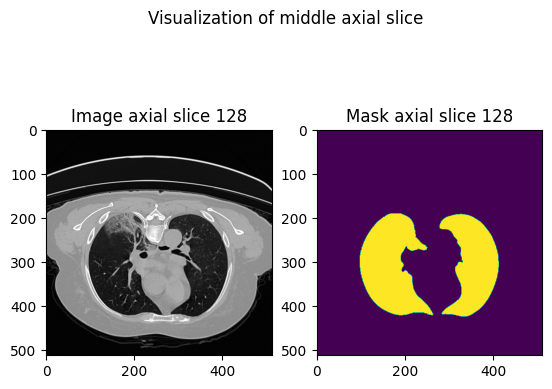

In [12]:
# Visualize data
if len(debug_train) == 0:
    print("No data found in debug_train!")
else:
    random_ct, random_lung_mask, metadata = random.choice(debug_train)
    
    print(f"Metadata: {metadata}")
    print(f"Image shape: {random_ct.shape}", f"Mask shape: {random_lung_mask.shape}")
    print(f"Image max after transforms if applicable: {random_ct.max()}")
    print(f"Image min after transforms if applicable: {random_ct.min()}")

    print(f"Length of debug_train: {len(debug_train)}")

    mid_slice = random_ct.shape[1]//2

    plt.suptitle("Visualization of middle axial slice")
    plt.subplot(1, 2, 1)
    plt.title(f"Image axial slice {mid_slice}")
    plt.imshow(random_ct[0, mid_slice], cmap="gray")
    plt.subplot(1, 2, 2)
    plt.title(f"Mask axial slice {mid_slice}")
    plt.imshow(random_lung_mask[0, mid_slice])
    plt.show()

In [13]:
# Visualize data list
debug_train.cts, debug_val.cts, debug_test.cts

(['d:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_002.nii.gz',
  'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_003.nii.gz',
  'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_004.nii.gz',
  'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_005.nii.gz',
  'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_006.nii.gz',
  'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_007.nii.gz',
  'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_008.nii.gz',
  'd:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\train\\coronacases_009.nii.gz'],
 ['d:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\val\\coronacases_010.nii.gz'],
 ['d:\\GitHub Repositories\\DL\\Medical-Imaging-Tutorial\\raw\\test\\coronacases_001.nii.gz'])

## Preprocessing and Saving images as  2D data


In [14]:
def preprocess():
    '''
    Initialize 3D datasets and save npz 2D slices in preprocessed folder
    '''
    transform = Compose([Clip(-1024, 600),
                              MinMaxNormalize()])

    for mode in ["train", "val", "test"]:
        os.makedirs(os.path.join(PROCESSED_DATA_FOLDER, mode), exist_ok=True)
        raw_data = RawCTDataset(mode, transform=transform)

        tqdm_iter = tqdm(raw_data, leave=True, position=0, desc="Preprocessing...")
        for img, tgt, metadata in tqdm_iter:
            ID = metadata["image_ID"]
            tqdm_iter.write(f"Processing {ID}...")
            img = img.transpose(1, 0, 2, 3)  # [C, slices, ...] -> [slices, C, ...]
            tgt = tgt.transpose(1, 0, 2, 3)
            for i, (img_slice, tgt_slice) in enumerate(zip(img, tgt)):
                save_path = os.path.join(PROCESSED_DATA_FOLDER, mode, f"{ID}_{i}.npz")
                np.savez_compressed(save_path, img=img_slice, tgt=tgt_slice)

    with open(os.path.join(PROCESSED_DATA_FOLDER, "done.txt"), 'w') as done_file:
        done_file.write("Done.")
        print("Completed!")

if not os.path.exists(os.path.join(PROCESSED_DATA_FOLDER, "done.txt")):
    preprocess()
else:
    print(f"Preprocessed data already present. If you want to re-run preprocessing, delete the contents of the {PROCESSED_DATA_FOLDER} folder.")

Preprocessed data already present. If you want to re-run preprocessing, delete the contents of the d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\preprocessed folder.


### Newly added cells

In [15]:
class PreprocessedDataset(Dataset):
    def __init__(self, mode: str, transform=None):
        self.transform = transform
        self.data_files = sorted(glob(os.path.join(PROCESSED_DATA_FOLDER, mode, "*.npz")))

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        img = data['img']
        tgt = data['tgt']

        if self.transform:
            img, tgt = self.transform((img, tgt))

        return torch.tensor(img, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)


In [18]:
# Define transform again if needed (can be None since data is already preprocessed)
transform = None

# Create datasets
train_dataset = PreprocessedDataset("train", transform=transform)
val_dataset = PreprocessedDataset("val", transform=transform)
test_dataset = PreprocessedDataset("test", transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True)

# Quick check
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Train samples: 1979
Validation samples: 301
Test samples: 301


In [19]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[32, 64, 128]):
        super(UNet, self).__init__()
        
        # Encoder
        self.downs = nn.ModuleList()
        for feature in features:
            self.downs.append(self._conv_block(in_channels, feature))
            in_channels = feature
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bottleneck
        self.bottleneck = self._conv_block(features[-1], features[-1]*2)
        
        # Decoder
        self.ups = nn.ModuleList()
        self.up_convs = nn.ModuleList()
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.up_convs.append(self._conv_block(feature*2, feature))
        
        # Final conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for i in range(len(self.ups)):
            x = self.ups[i](x)
            skip_connection = skip_connections[i]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            x = torch.cat((skip_connection, x), dim=1)
            x = self.up_convs[i](x)

        return torch.sigmoid(self.final_conv(x))  # output between 0 and 1

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


In [20]:
class LungSegmentationModel(pl.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.model = UNet(in_channels=1, out_channels=1)
        self.lr = lr
        self.loss_fn = self.combined_loss  # Dice + BCE

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.lr)

    def dice_loss(self, preds, targets, smooth=1e-5):
        preds = preds.view(-1)
        targets = targets.view(-1)
        intersection = (preds * targets).sum()
        dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
        return 1 - dice

    def combined_loss(self, preds, targets):
        bce = F.binary_cross_entropy(preds, targets)
        dice = self.dice_loss(preds, targets)
        return bce + dice


Train samples: 1979
Validation samples: 301
Test samples: 301
Timing DataLoader...


Train Loader Timing: 100%|██████████| 495/495 [00:41<00:00, 11.94it/s]


Time to loop through train set: 41.46 seconds
Image batch shape: torch.Size([4, 1, 512, 512])
Mask batch shape: torch.Size([4, 1, 512, 512])


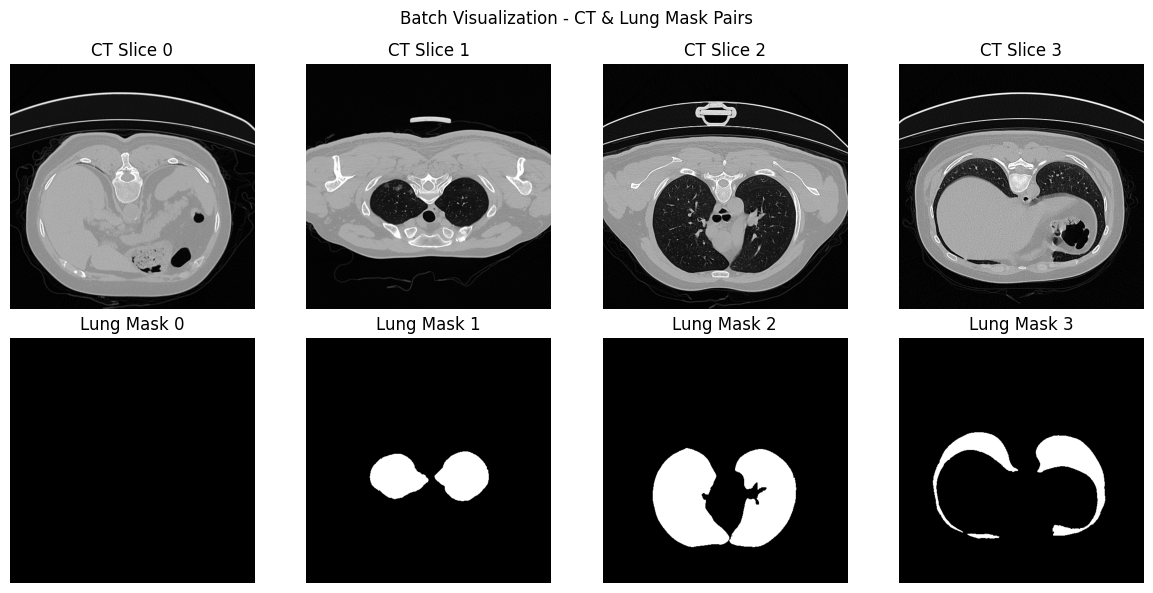

In [ ]:
# PreprocessedDataset class 
class PreprocessedDataset(Dataset):
    def __init__(self, mode: str, transform=None):
        self.transform = transform
        self.data_files = sorted(glob(os.path.join(PROCESSED_DATA_FOLDER, mode, "*.npz")))

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data = np.load(self.data_files[idx])
        img = data['img']
        tgt = data['tgt']

        if self.transform:
            img, tgt = self.transform((img, tgt))

        return torch.tensor(img, dtype=torch.float32), torch.tensor(tgt, dtype=torch.float32)

# Set transform to None (data already preprocessed)
transform = None

# Create dataset instances
train_dataset = PreprocessedDataset("train", transform=transform)
val_dataset = PreprocessedDataset("val", transform=transform)
test_dataset = PreprocessedDataset("test", transform=transform)

# Create DataLoaders (optimized for Windows + CPU)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=False)

# Check dataset sizes
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Time the DataLoader loop
import time
from tqdm import tqdm

print("Timing DataLoader...")
start = time.time()
for batch in tqdm(train_loader, desc="Train Loader Timing"):
    pass
print(f"Time to loop through train set: {time.time() - start:.2f} seconds")

# Visualize a batch
batch = next(iter(train_loader))
images, masks = batch

print(f"Image batch shape: {images.shape}")  # [B, 1, H, W]
print(f"Mask batch shape: {masks.shape}")

# Plot first 4 images and masks
num_to_plot = min(4, images.shape[0])
plt.figure(figsize=(12, 6))
for i in range(num_to_plot):
    plt.subplot(2, num_to_plot, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"CT Slice {i}")
    plt.axis('off')

    plt.subplot(2, num_to_plot, num_to_plot + i + 1)
    plt.imshow(masks[i][0], cmap="gray")
    plt.title(f"Lung Mask {i}")
    plt.axis('off')

plt.suptitle("Batch Visualization - CT & Lung Mask Pairs")
plt.tight_layout()
plt.show()

In [ ]:
# Load best checkpoint from saved path
best_model_path = "logs/lung_segmentation/version_0/checkpoints/best-checkpoint.ckpt"

# Load model directly from checkpoint
best_model = LungSegmentationModel.load_from_checkpoint(best_model_path, lr=1e-3)
best_model.eval()
best_model.freeze()


In [ ]:
# Import only if not already
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

# Logger & checkpoint setup
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    mode="min",
    filename="best-checkpoint",
)

logger = CSVLogger("logs", name="lung_segmentation")

# Instantiate model
model = LungSegmentationModel(lr=1e-3)

# Trainer
trainer = Trainer(
    max_epochs=5,               # Keep small to reduce training time
    accelerator="cpu",          # Use CPU explicitly
    callbacks=[checkpoint_callback],
    logger=logger,
    log_every_n_steps=5,
    enable_progress_bar=True,
    deterministic=True
)

# Start training
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


Best model saved at: logs\lung_segmentation\version_0\checkpoints\best-checkpoint.ckpt


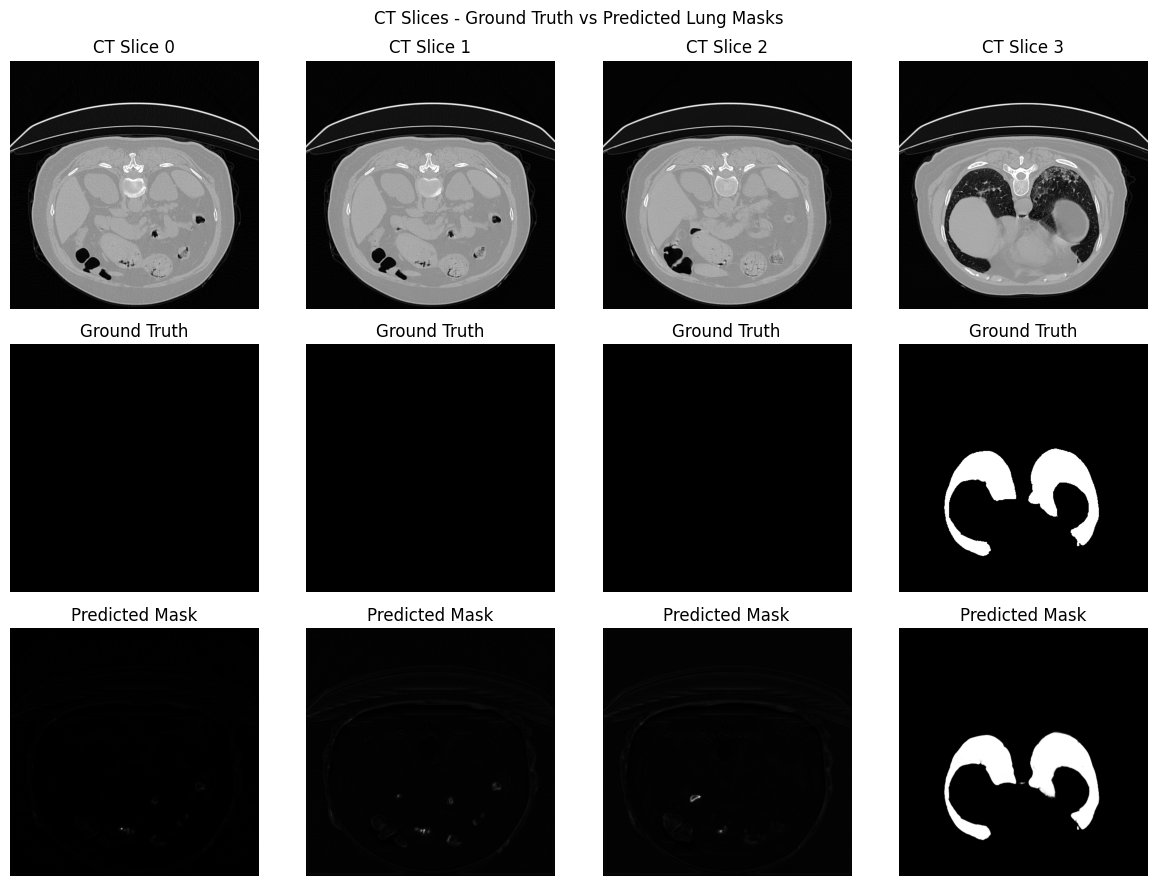

In [23]:
# Load best checkpoint (ensure the path matches saved model)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

# Load model from checkpoint
best_model = LungSegmentationModel.load_from_checkpoint(best_model_path, lr=1e-3)
best_model.eval()
best_model.freeze()

# Pick a few test samples and visualize predictions
num_to_visualize = 4
test_batch = next(iter(test_loader))
x_test, y_test = test_batch

with torch.no_grad():
    preds = best_model(x_test)

# Plot
plt.figure(figsize=(12, 9))
for i in range(min(num_to_visualize, x_test.shape[0])):
    plt.subplot(3, num_to_visualize, i + 1)
    plt.imshow(x_test[i][0], cmap='gray')
    plt.title(f"CT Slice {i}")
    plt.axis('off')

    plt.subplot(3, num_to_visualize, num_to_visualize + i + 1)
    plt.imshow(y_test[i][0], cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(3, num_to_visualize, 2 * num_to_visualize + i + 1)
    plt.imshow(preds[i][0], cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.suptitle("CT Slices - Ground Truth vs Predicted Lung Masks")
plt.tight_layout()
plt.show()


In [ ]:
# Compute Dice & IoU on Test Set
def compute_metrics(preds, targets, threshold=0.5, smooth=1e-6):
    preds = (preds > threshold).float()

    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)

    # Fix: remove smooth from tuple!
    iou = (intersection + smooth) / (preds + targets - preds * targets + smooth).sum(dim=(1, 2, 3))

    return dice.mean().item(), iou.mean().item()

# Gather all test metrics
dice_scores = []
iou_scores = []

best_model.eval()
with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Evaluating Test Set"):
        y_pred = best_model(x_batch)
        dice, iou = compute_metrics(y_pred, y_batch)
        dice_scores.append(dice)
        iou_scores.append(iou)

avg_dice = np.mean(dice_scores)
avg_iou = np.mean(iou_scores)

print(f"✅ Average Dice Score on Test Set: {avg_dice:.4f}")
print(f"✅ Average IoU Score on Test Set: {avg_iou:.4f}")


Evaluating Test Set: 100%|██████████| 76/76 [03:42<00:00,  2.92s/it]

✅ Average Dice Score on Test Set: 0.9664
✅ Average IoU Score on Test Set: 0.7162


In [ ]:
# Import Predictions
sample = np.load("predictions/test_0.npz")
plt.imshow(sample["image"], cmap="gray")
plt.imshow(sample["prediction"], alpha=0.4)


In [26]:

EXPORT_FOLDER = os.path.join(PROJECT_ROOT, "predictions")
os.makedirs(EXPORT_FOLDER, exist_ok=True)

# For each test sample, save image, prediction, and mask
best_model.eval()
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Saving predictions")):
        preds = best_model(x_batch)
        preds = (preds > 0.5).float()  # binarize prediction

        for j in range(x_batch.shape[0]):
            image_np = x_batch[j][0].numpy()
            mask_np = y_batch[j][0].numpy()
            pred_np = preds[j][0].numpy()

            save_name = f"test_{i * test_loader.batch_size + j}.npz"
            save_path = os.path.join(EXPORT_FOLDER, save_name)

            np.savez_compressed(save_path, image=image_np, mask=mask_np, prediction=pred_np)

print(f"✅ Exported predictions to: {EXPORT_FOLDER}")


Saving predictions: 100%|██████████| 76/76 [04:43<00:00,  3.73s/it]

✅ Exported predictions to: d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\predictions


### Performance analysis

In [ ]:
# Compute & Save Per-Sample Dice + IoU to CSV

import pandas as pd

# Store individual metrics
results = []

best_model.eval()
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Computing per-sample metrics")):
        y_pred = best_model(x_batch)
        y_pred = y_pred.detach()

        for j in range(x_batch.shape[0]):
            dice, iou = compute_metrics(y_pred[j:j+1], y_batch[j:j+1])
            sample_idx = i * test_loader.batch_size + j
            results.append({
                "sample_index": sample_idx,
                "dice_score": dice,
                "iou_score": iou
            })

# Convert to DataFrame
df_metrics = pd.DataFrame(results)

# Save to CSV
csv_path = os.path.join(PROJECT_ROOT, "lung_segmentation_test_metrics.csv")
df_metrics.to_csv(csv_path, index=False)
print(f"✅ Saved per-sample metrics to: {csv_path}")


Computing per-sample metrics: 100%|██████████| 76/76 [02:51<00:00,  2.26s/it]

✅ Saved per-sample metrics to: d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\lung_segmentation_test_metrics.csv


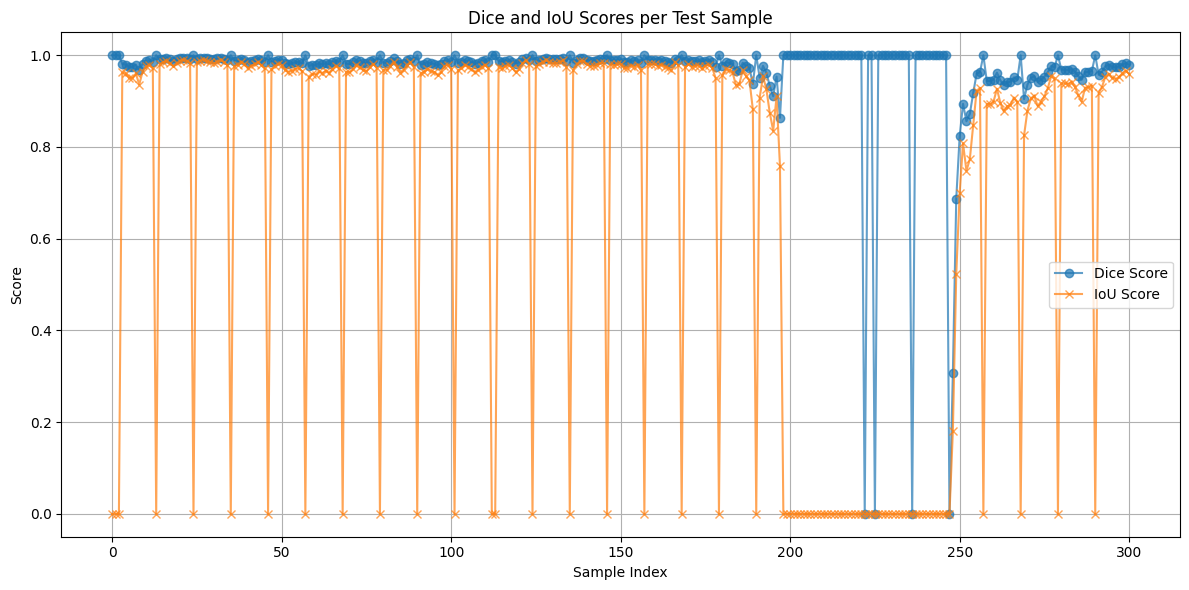

In [ ]:
# Plot Dice & IoU per Sample - Line Plot of Scores
plt.figure(figsize=(12, 6))

plt.plot(df_metrics["dice_score"], label="Dice Score", marker='o', alpha=0.7)
plt.plot(df_metrics["iou_score"], label="IoU Score", marker='x', alpha=0.7)
plt.title("Dice and IoU Scores per Test Sample")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


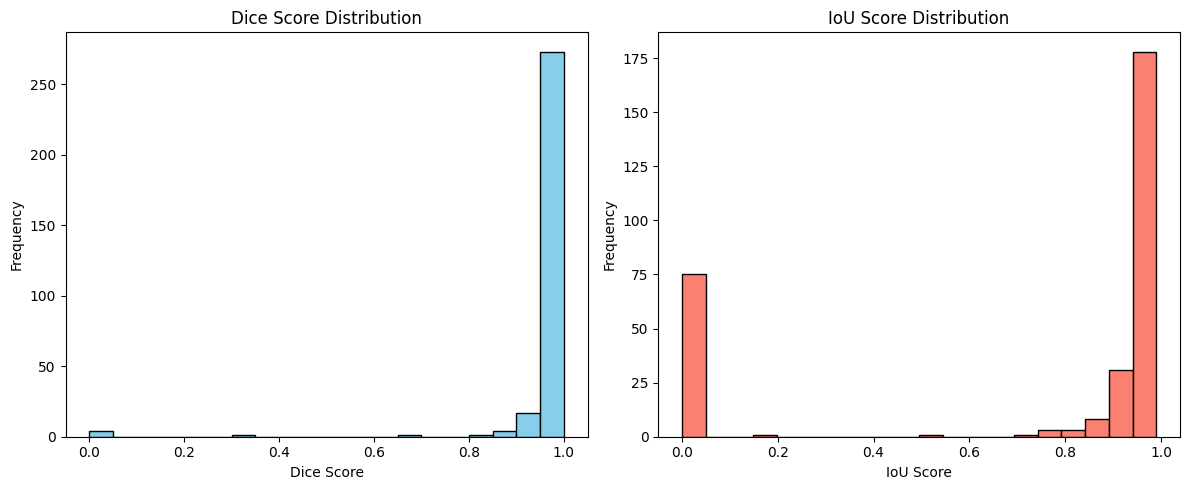

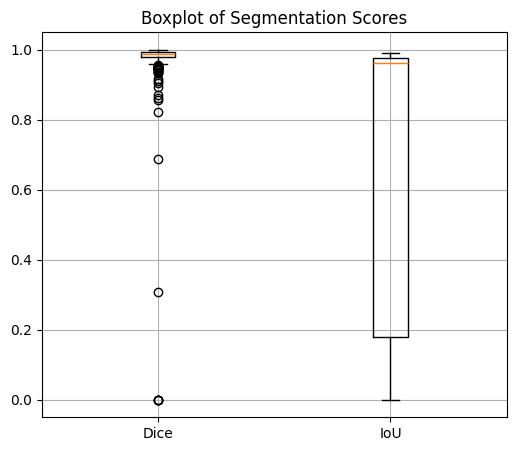

In [30]:
# Performance Distribution (Histograms)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df_metrics["dice_score"], bins=20, color='skyblue', edgecolor='black')
plt.title("Dice Score Distribution")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df_metrics["iou_score"], bins=20, color='salmon', edgecolor='black')
plt.title("IoU Score Distribution")
plt.xlabel("IoU Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Boxplot (optional)
plt.figure(figsize=(6, 5))
plt.boxplot([df_metrics["dice_score"], df_metrics["iou_score"]], labels=["Dice", "IoU"])
plt.title("Boxplot of Segmentation Scores")
plt.grid(True)
plt.show()


In [31]:
# View worst predictions (e.g., Dice < 0.5)
low_dice_samples = df_metrics[df_metrics["dice_score"] < 0.5].sort_values(by="dice_score")

print("⚠️ Samples with Dice < 0.5:")
print(low_dice_samples.head())

# You can visualize any of these later with:
# sample_index = low_dice_samples.iloc[0]["sample_index"]


⚠️ Samples with Dice < 0.5:
     sample_index    dice_score     iou_score
247           247  4.524887e-09  4.519528e-09
222           222  1.666666e-07  1.596898e-07
225           225  1.666666e-07  1.596898e-07
236           236  9.999991e-07  7.923028e-07
248           248  3.066667e-01  1.807294e-01


In [32]:
# Sort the DataFrame by Dice score
df_sorted = df_metrics.sort_values(by="dice_score", ascending=False)

top5 = df_sorted.head(5)
bottom5 = df_sorted.tail(5)

print("⭐ Top 5 Predictions by Dice Score:")
print(top5)

print("\n❌ Bottom 5 Predictions by Dice Score:")
print(bottom5)


⭐ Top 5 Predictions by Dice Score:
     sample_index  dice_score  iou_score
0               0         1.0   0.000004
207           207         1.0   0.000004
209           209         1.0   0.000004
210           210         1.0   0.000004
211           211         1.0   0.000004

❌ Bottom 5 Predictions by Dice Score:
     sample_index    dice_score     iou_score
248           248  3.066667e-01  1.807294e-01
236           236  9.999991e-07  7.923028e-07
222           222  1.666666e-07  1.596898e-07
225           225  1.666666e-07  1.596898e-07
247           247  4.524887e-09  4.519528e-09


In [ ]:
# Save All Predictions as .png and .nii.gz
import imageio
import nibabel as nib

EXPORT_IMG_DIR = os.path.join(PROJECT_ROOT, "exported_masks")
os.makedirs(EXPORT_IMG_DIR, exist_ok=True)

# Save the first N predictions (or loop all if desired)
N = 10
counter = 0

best_model.eval()
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Exporting PNG/NIfTI")):
        y_pred = best_model(x_batch)
        y_pred = (y_pred > 0.5).float()

        for j in range(x_batch.shape[0]):
            image = x_batch[j][0].numpy()
            mask = y_batch[j][0].numpy()
            pred = y_pred[j][0].numpy()

            # Save as .png
            base_name = f"sample_{counter}"
            imageio.imwrite(os.path.join(EXPORT_IMG_DIR, f"{base_name}_image.png"), (image * 255).astype("uint8"))
            imageio.imwrite(os.path.join(EXPORT_IMG_DIR, f"{base_name}_mask.png"), (mask * 255).astype("uint8"))
            imageio.imwrite(os.path.join(EXPORT_IMG_DIR, f"{base_name}_pred.png"), (pred * 255).astype("uint8"))

            # Save as .nii.gz
            nib.save(nib.Nifti1Image(image, affine=np.eye(4)), os.path.join(EXPORT_IMG_DIR, f"{base_name}_image.nii.gz"))
            nib.save(nib.Nifti1Image(mask, affine=np.eye(4)), os.path.join(EXPORT_IMG_DIR, f"{base_name}_mask.nii.gz"))
            nib.save(nib.Nifti1Image(pred, affine=np.eye(4)), os.path.join(EXPORT_IMG_DIR, f"{base_name}_pred.nii.gz"))

            counter += 1
            if counter >= N:
                break
        if counter >= N:
            break

print(f"✅ Exported {N} predictions to: {EXPORT_IMG_DIR}")


Exporting PNG/NIfTI:   3%|▎         | 2/76 [00:07<04:54,  3.98s/it]

✅ Exported 10 predictions to: d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\exported_masks


In [ ]:
# Estimate Prediction Uncertainty (Per Sample)
uncertainties = []

best_model.eval()
with torch.no_grad():
    for x_batch, _ in tqdm(test_loader, desc="Estimating uncertainty"):
        y_pred = best_model(x_batch)
        batch_std = y_pred.std(dim=(1, 2, 3))  # std across pixels per image
        uncertainties.extend(batch_std.cpu().numpy())

df_metrics["uncertainty"] = uncertainties
print(df_metrics[["sample_index", "dice_score", "uncertainty"]].head())


Estimating uncertainty: 100%|██████████| 76/76 [03:42<00:00,  2.92s/it]

   sample_index  dice_score  uncertainty
0             0    1.000000     0.000260
1             1    1.000000     0.000198
2             2    1.000000     0.000220
3             3    0.980939     0.284394
4             4    0.979732     0.290383


In [ ]:
# Generate Mini Performance Report
report_path = os.path.join(PROJECT_ROOT, "model_report.txt")

with open(report_path, "w") as f:
    f.write("Lung Segmentation - Performance Summary\n")
    f.write("=======================================\n")
    f.write(f"Total test samples: {len(df_metrics)}\n")
    f.write(f"Average Dice Score: {df_metrics['dice_score'].mean():.4f}\n")
    f.write(f"Average IoU Score : {df_metrics['iou_score'].mean():.4f}\n")
    f.write(f"Mean Uncertainty  : {df_metrics['uncertainty'].mean():.6f}\n")
    f.write("\nTop 5 Best Samples:\n")
    f.write(df_sorted.head(5).to_string(index=False))
    f.write("\n\nBottom 5 Worst Samples:\n")
    f.write(df_sorted.tail(5).to_string(index=False))

print(f"✅ Saved mini report to: {report_path}")


✅ Saved mini report to: d:\GitHub Repositories\DL\Medical-Imaging-Tutorial\model_report.txt


In [39]:
# Save line plot
plt.figure(figsize=(12, 6))
plt.plot(df_metrics["dice_score"], label="Dice Score", marker='o', alpha=0.7)
plt.plot(df_metrics["iou_score"], label="IoU Score", marker='x', alpha=0.7)
plt.title("Dice and IoU Scores per Test Sample")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, "plot_dice_iou_per_sample.png"))
plt.close()

# Save histograms
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(df_metrics["dice_score"], bins=20, color='skyblue', edgecolor='black')
plt.title("Dice Score Distribution")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(df_metrics["iou_score"], bins=20, color='salmon', edgecolor='black')
plt.title("IoU Score Distribution")
plt.xlabel("IoU Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, "plot_score_distributions.png"))
plt.close()

print("✅ Saved plots as PNG files in your project root folder.")


✅ Saved plots as PNG files in your project root folder.


In [41]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

def compute_classification_metrics(preds, targets, threshold=0.5):
    preds = (preds > threshold).cpu().numpy().astype("uint8").flatten()
    targets = targets.cpu().numpy().astype("uint8").flatten()

    precision = precision_score(targets, preds, zero_division=0)
    recall = recall_score(targets, preds, zero_division=0)
    f1 = f1_score(targets, preds, zero_division=0)

    # Confusion matrix
    cm = confusion_matrix(targets, preds, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    specificity = tn / (tn + fp + 1e-6)

    return precision, recall, f1, specificity, cm


In [42]:
classification_results = []
confusion_matrices = []

best_model.eval()
with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(tqdm(test_loader, desc="Classification Metrics")):
        y_pred = best_model(x_batch)

        for j in range(x_batch.shape[0]):
            p, r, f1, spec, cm = compute_classification_metrics(y_pred[j][0], y_batch[j][0])
            sample_index = i * test_loader.batch_size + j
            classification_results.append({
                "sample_index": sample_index,
                "precision": p,
                "recall": r,
                "f1_score": f1,
                "specificity": spec
            })
            confusion_matrices.append(cm)


Classification Metrics: 100%|██████████| 76/76 [04:40<00:00,  3.69s/it]


In [43]:
# Merge with existing df_metrics
df_classification = pd.DataFrame(classification_results)
df_metrics = df_metrics.merge(df_classification, on="sample_index")

# Save to CSV
df_metrics.to_csv(os.path.join(PROJECT_ROOT, "lung_segmentation_metrics_all.csv"), index=False)
print("✅ Saved all metrics to CSV.")

# Print average scores
print("\n📊 Averages:")
print(f"Precision   : {df_metrics['precision'].mean():.4f}")
print(f"Recall      : {df_metrics['recall'].mean():.4f}")
print(f"F1 Score    : {df_metrics['f1_score'].mean():.4f}")
print(f"Specificity : {df_metrics['specificity'].mean():.4f}")
    

✅ Saved all metrics to CSV.

📊 Averages:
Precision   : 0.7417
Recall      : 0.7223
F1 Score    : 0.7304
Specificity : 0.9992


***The following are GitHub project cells***

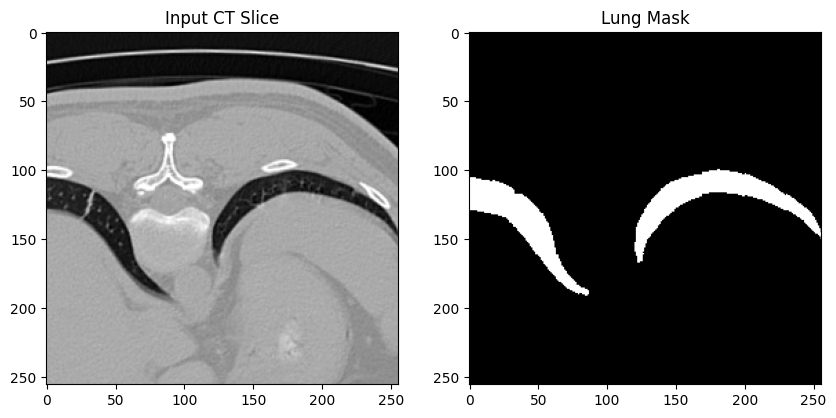

In [49]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Use the same loader that worked before
loader = DataLoader(CTDataset("train", transform=get_transform("rotate_crop")),
                    batch_size=4, shuffle=True, num_workers=0)

img_batch, tgt_batch = next(iter(loader))

# Show just the first sample in the batch
img = img_batch[0].squeeze().numpy()  # shape: [256, 256]
mask = tgt_batch[0].squeeze().numpy()  # shape: [256, 256]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Input CT Slice")
plt.imshow(img, cmap="gray")

plt.subplot(1, 2, 2)
plt.title("Lung Mask")
plt.imshow(mask, cmap="gray")
plt.show()


# Metrics and Post-Processing

Checking the images, it is possible to see that we have noise in the predictions.
It is important to remove this noise (using 3D connected components) and set the best threshold to binarize your output.



In [ ]:
def seg_metrics(gts: np.ndarray, preds: np.ndarray, metrics: Dict[str, Dict[str, List[float]]], struct_names=["bg", "healthy", "unhealthy"]):
    '''
    finds overlap and distance measures of two given segmentations.
    "Overlap measures: Dice, FNError, FPError, jaccard, Volume Similarity (SimpleITK) and Volume Similarity(Taha et al)
    "Distance measures: Hausdorff distance and average hausdorff distance
    '''
    assert (len(gts.shape) == len(preds.shape) and
            isinstance(gts, np.ndarray) and isinstance(preds, np.ndarray) and gts.dtype == np.uint8 and preds.dtype == np.uint8 and
            (gts >= 0).all() and (gts <= 1).all() and (preds <= 1).all() and (preds >= 0).all()), "Malformed input for seg_metrics"

    for gt, pred, str_label in zip(gts, preds, struct_names):
        hausdorff_distance_filter = sitk.HausdorffDistanceImageFilter()
        overlap_measures_filter = sitk.LabelOverlapMeasuresImageFilter()

        img_gt_sitk = sitk.GetImageFromArray(gt)
        img_pred_sitk = sitk.GetImageFromArray(pred)

        overlap_measures_filter.Execute(img_gt_sitk, img_pred_sitk)

        metrics[str_label]["dice"].append(overlap_measures_filter.GetDiceCoefficient())
        metrics[str_label]["false_negative_error"].append(overlap_measures_filter.GetFalseNegativeError())
        metrics[str_label]["false_positive_error"].append(overlap_measures_filter.GetFalsePositiveError())
        metrics[str_label]["jaccard"].append(overlap_measures_filter.GetJaccardCoefficient())
        metrics[str_label]["volume_similarity"].append(overlap_measures_filter.GetVolumeSimilarity())
        metrics[str_label]["abs_volume_similatiry"].append(1-abs(overlap_measures_filter.GetVolumeSimilarity())/2)

        try:
            hausdorff_distance_filter.Execute(img_gt_sitk, img_pred_sitk)
            metrics[str_label]["avg_hd"].append(hausdorff_distance_filter.GetAverageHausdorffDistance())
            metrics[str_label]["hd"].append(hausdorff_distance_filter.GetHausdorffDistance())
        except:
            metrics[str_label]["avg_hd"].append(nan)
            metrics[str_label]["hd"].append(nan)
